The purpose of this notebook is to generate a scene-wise feature space for the meta-MDP 

In [33]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import spearmanr
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from scipy import stats
from pylab import figure, text, scatter, show

In [2]:
## Set data directory.
data_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/'

## Import objects and their locations. 
object_locations = pd.read_csv(data_direc + '/location/location_all_objects_tagged.csv')

## Get unique scenes and objects.
_, idx = np.unique(object_locations['scene'].values, return_index=True)
all_scenes = list(object_locations['scene'].values[np.sort(idx)])
all_objects = np.unique(object_locations['object'].values)

## Import features.
layer = 'block5_pool'

shape = pd.read_csv(data_direc + '/shape/pca/pca_all_objects.csv')
color = pd.read_csv(data_direc + '/color/pca/pca_all_objects.csv')
vgg = pd.read_csv(data_direc + '/vgg/pca/' + layer + '_pca_all_objects.csv')

## Get maximum possible number of objects. 
n_objects = []
[n_objects.append(len(object_locations[object_locations['scene'] == s])) for s in all_scenes]
max_no = np.max(np.array(n_objects))

In [3]:
## Z-score. 
shape_zscored = pd.DataFrame(stats.zscore(shape[shape.columns[1:None]].values, axis=0))
color_zscored = pd.DataFrame(stats.zscore(color[color.columns[1:None]].values, axis=0))
vgg_zscored = pd.DataFrame(stats.zscore(vgg[vgg.columns[1:None]].values, axis=0))

shape_zscored.insert(0,'object', shape['object'].values)
color_zscored.insert(0,'object', color['object'].values)
vgg_zscored.insert(0,'object', vgg['object'].values)

shape_zscored.columns = shape.columns
color_zscored.columns = color.columns
vgg_zscored.columns = vgg.columns

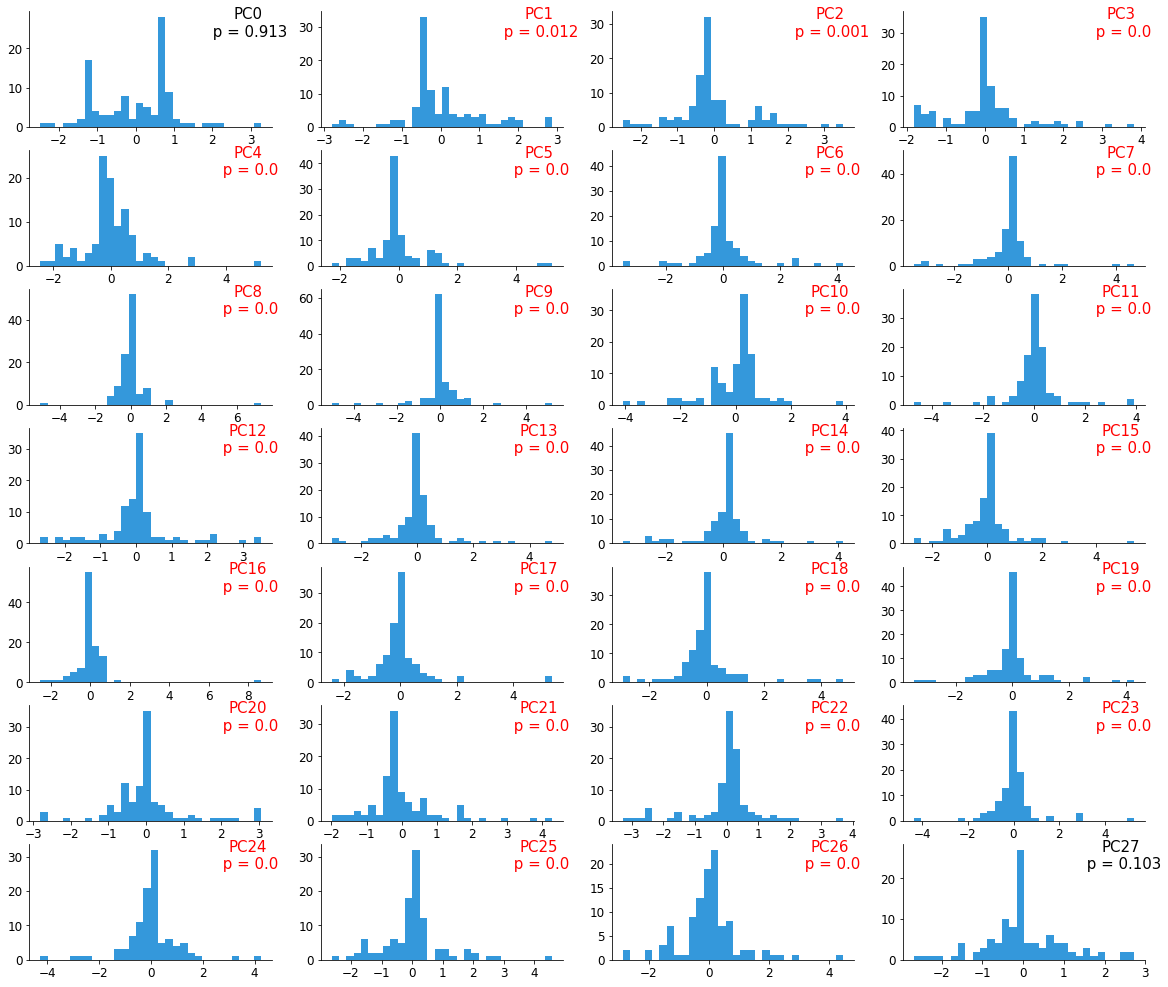

In [58]:
## Test for normality.
features_aux = color_zscored.iloc[: , 1:]

purples = ["#D8BFD8", "#9b59b6"]
blues = ["#c1e1ec", "#3498db"]
greens = ["#addd8e", "#61a96a"]

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20,20))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        
        k2, p = stats.normaltest(df[var_name].values)
        
        tstring = "PC" + str(var_name) + "\n p = " + str(np.round(p, 3))
        
        if p < 0.05: 
            text_col = 'red'
        else: 
            text_col = 'black'
            
        text(0.9, 0.9, tstring, ha='center', va='center', transform=ax.transAxes, color=text_col, size=15)
        
        df[var_name].hist(bins=30,ax=ax, color=blues[1])
    
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
        ax.grid(False)
        sns.despine()
    plt.show()

draw_histograms(features_aux, features_aux.columns, 8, 4)

,0,1,2,3,4
0,1.000000,-0.218747,-0.099397,-0.229569,-0.147433
1,-0.218747,1.000000,0.001360,0.019146,-0.066204
2,-0.099397,0.001360,1.000000,-0.108698,-0.302092
3,-0.229569,0.019146,-0.108698,1.000000,0.182944
4,-0.147433,-0.066204,-0.302092,0.182944,1.000000


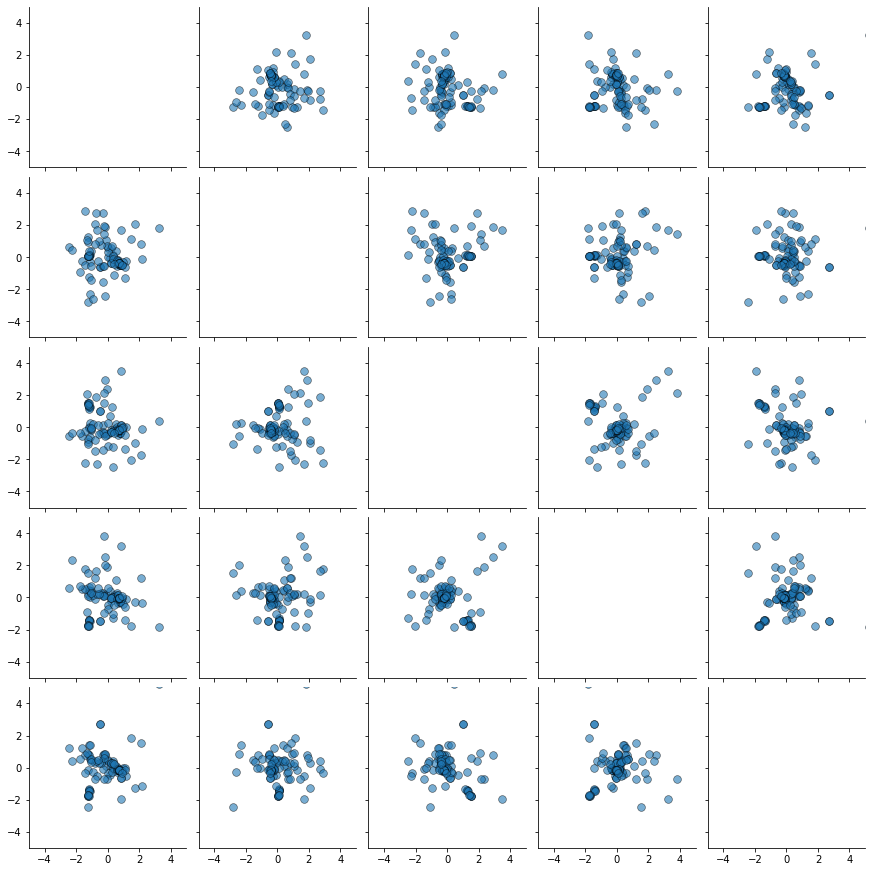

In [60]:
## Plot pairs of feature pairs. 
N = 5

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = spearmanr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

# Select first N columns
first_N  = color_zscored.iloc[:, :N+1]
first_N = first_N.drop(['object'], axis=1)
g = sns.pairplot(first_N, diag_kind = 'none', 
             plot_kws = {'alpha': 0.6, 's': 60, 'edgecolor': 'k'});

g.set(xlim=[-5,5])  
g.set(ylim=[-5,5])  
g.set(xlabel=None)  
g.set(ylabel=None);

first_N.corr(method='spearman')

In [6]:
## Set number of PCs to preserve.  
n_pcs_shape =  len(shape_zscored.columns)-1
n_pcs_color =  len(color_zscored.columns)-1
n_pcs_vgg =  len(vgg_zscored.columns)-1

pc_cols_shape = np.arange(n_pcs_shape)
pc_cols_color = np.arange(n_pcs_color)
pc_cols_vgg =  np.arange(n_pcs_vgg)

print(n_pcs_shape)
print(n_pcs_color)
print(n_pcs_vgg)

## Make feature space DF. 
feature_space = object_locations.copy()
shape_cols = ["shape_" + str(pc) for pc in np.arange(n_pcs_shape)+1]
color_cols = ["color_" + str(pc) for pc in np.arange(n_pcs_color)+1]
vgg_cols = ["vgg_" + layer + '_' + str(pc) for pc in np.arange(n_pcs_vgg)+1]

shape_dict = {i : np.nan for i in shape_cols}
color_dict = {i : np.nan for i in color_cols}
vgg_dict = {i : np.nan for i in vgg_cols}

feature_space = feature_space.assign(**shape_dict)
feature_space = feature_space.assign(**color_dict)
feature_space = feature_space.assign(**vgg_dict)

7
28
19


In [7]:
## Loop through objects to get color and shape properties. 
for o in all_objects: 
     
    ## Retrieve feature info for this object.
    object_shape = shape_zscored.loc[shape_zscored['object'] == o][list(map(str, pc_cols_shape))].reset_index(drop=True)
    object_color = color_zscored.loc[color_zscored['object'] == o][list(map(str, pc_cols_color))].reset_index(drop=True)
    object_vgg = vgg_zscored.loc[vgg_zscored['object'] == o][list(map(str, pc_cols_vgg))].reset_index(drop=True)
    
    ## Find when this object was present in a scene. 
    idx_o = np.where(object_locations['object'] == o)
    
    ## Fill in feature info. 
    feature_space.loc[feature_space.index[idx_o[0]], shape_cols] = object_shape.values
    feature_space.loc[feature_space.index[idx_o[0]], color_cols] = object_color.values
    feature_space.loc[feature_space.index[idx_o[0]], vgg_cols] = object_vgg.values

In [8]:
## Define vector normalization function.
def norm_vec(v): 
    return v/np.linalg.norm(v)

In [9]:
## Pad up to maximum number of objects in a scene. 
feature_space_padded = []

for s in all_scenes:
    
    ## How many objects in scene?
    this_scene = feature_space[feature_space['scene'] == s]
    l = len(this_scene)
    
    ## Normalize xyz position to unit vector.
    v_list = []
    N = this_scene[['x','y','z']].values.shape[0]
    for n in np.arange(N):
        v_list.append(this_scene[['x','y','z']].values[n,:])
    xyz_norm = np.vstack([norm_vec(v) for v in v_list])
    
    ## Replace old values with normalized values. 
    this_scene = this_scene.assign(x=xyz_norm[:,0])
    this_scene = this_scene.assign(y=xyz_norm[:,1])
    this_scene = this_scene.assign(z=xyz_norm[:,2])
    
    if l < max_no:
            
        ## Generate padding up to maximum number of objects. 
        df_pad = this_scene.head(1).reset_index(drop=True)
        n_pad = max_no - l
    
        padding = []
        for i in np.arange(n_pad):
            padding.append(df_pad)
        padding = pd.concat(padding).reset_index(drop=True)
        
        padding['object'] = 'Pad'
        padding['x'] = 0
        padding['y'] = 0
        padding['z'] = 0
        padding['r_polar'] = 0
        padding['theta_polar'] = 0
        padding['object_idx'] = np.arange(len(padding))
        padding['x_pos_pixel_360'] = 8192/2
        padding['y_pos_pixel_360'] = 4096/2
        padding[shape_cols] = 0
        padding[color_cols] = 0
        padding[vgg_cols] = 0
        
        this_scene_padded = pd.concat([this_scene, padding])
    
    else: 
        
        this_scene_padded = this_scene
        
    feature_space_padded.append(this_scene_padded)

feature_space_padded = pd.concat(feature_space_padded).reset_index(drop=True)
feature_space_padded.to_csv(data_direc + 'metamdp_feature_space.csv', index=False)

In [15]:
len(np.unique(feature_space_padded['object']))

107

In [11]:
live_version = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/Cognitive-Science-Consortium/VisualSearch/MetaMDP/feature_space/metamdp_feature_space.csv'


In [12]:
df = pd.read_csv(live_version)

In [13]:
df.columns

Index(['scene', 'object', 'object_idx', 'x', 'y', 'z', 'r_polar',
       'theta_polar', 'x_pos_pixel_360', 'y_pos_pixel_360', 'location',
       'occluded', 'shape_1', 'shape_2', 'shape_3', 'shape_4', 'shape_5',
       'shape_6', 'shape_7', 'color_1', 'color_2', 'color_3', 'color_4',
       'color_5', 'color_6', 'color_7', 'color_8', 'color_9', 'color_10',
       'color_11', 'color_12', 'color_13', 'color_14', 'color_15', 'color_16',
       'color_17', 'color_18', 'color_19', 'color_20', 'color_21', 'color_22',
       'color_23', 'color_24', 'color_25', 'color_26', 'color_27', 'color_28',
       'color_29', 'color_30', 'color_31', 'color_32', 'color_33', 'color_34',
       'color_35', 'color_36', 'color_37', 'color_38', 'color_39', 'color_40',
       'color_41', 'color_42', 'color_43', 'color_44', 'color_45', 'color_46',
       'color_47', 'vgg_block5_pool_1', 'vgg_block5_pool_2',
       'vgg_block5_pool_3', 'vgg_block5_pool_4', 'vgg_block5_pool_5',
       'vgg_block5_pool_6', 'vgg_blo

In [129]:
df[['color_1','color_2']]

,color_1,color_2
0,0.410170,-1.097102
1,1.085544,-1.296587
2,0.897233,-0.498341
3,-1.187518,-1.171258
4,-1.227169,0.118714
...,...,...
33895,0.657499,-0.338556
33896,0.000000,0.000000
33897,0.000000,0.000000
33898,0.000000,0.000000


In [131]:
feature_space_padded.columns

Index(['scene', 'object', 'object_idx', 'x', 'y', 'z', 'r_polar',
       'theta_polar', 'x_pos_pixel_360', 'y_pos_pixel_360', 'location',
       'occluded', 'shape_1', 'shape_2', 'shape_3', 'shape_4', 'shape_5',
       'shape_6', 'shape_7', 'color_1', 'color_2', 'color_3', 'color_4',
       'color_5', 'color_6', 'color_7', 'color_8', 'color_9', 'color_10',
       'color_11', 'color_12', 'color_13', 'color_14', 'color_15', 'color_16',
       'color_17', 'color_18', 'color_19', 'color_20', 'color_21', 'color_22',
       'color_23', 'color_24', 'color_25', 'color_26', 'color_27', 'color_28',
       'color_29', 'color_30', 'color_31', 'color_32', 'color_33', 'color_34',
       'color_35', 'color_36', 'color_37', 'color_38', 'color_39', 'color_40',
       'color_41', 'color_42', 'color_43', 'color_44', 'color_45', 'color_46',
       'color_47', 'vgg_block5_pool_1', 'vgg_block5_pool_2',
       'vgg_block5_pool_3', 'vgg_block5_pool_4', 'vgg_block5_pool_5',
       'vgg_block5_pool_6', 'vgg_blo

In [123]:
from scipy.special import softmax

objects_in_patch = np.array([0, 0, 1, 0, 0, 1, 0, 1])
cooccurence_matrix = softmax(np.random.normal(size=(8,8)))

# p_target_in_patch = ?